In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [2]:
data_dir = "dataset/Bank_Marketing/"
data = pd.read_csv(data_dir + "bank-additional-full.csv", sep = ';')
data = data.sample(frac=0.5, replace=True, random_state=1).reset_index(drop=True)

data['y'].replace(['yes', 'no'], [0, 1], inplace=True)

data['job'].replace(['housemaid' , 'services' , 'admin.' , 'blue-collar' , 'technician', 'retired' , 'management', 'unemployed', 'self-employed', 'unknown' , 'entrepreneur', 'student'] , [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)

data['education'].replace(['basic.4y' , 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown' , 'university.degree' , 'illiterate'], [1, 2, 3, 4, 5, 6, 7, 8], inplace=True)

data['marital'].replace(['married', 'single', 'divorced', 'unknown'], [1, 2, 3, 4], inplace=True)

data['default'].replace(['yes', 'no', 'unknown'],[1, 2, 3], inplace=True)

data['housing'].replace(['yes', 'no', 'unknown'],[1, 2, 3], inplace=True)

data['loan'].replace(['yes', 'no', 'unknown'],[1, 2, 3], inplace=True)

data['poutcome'].replace(['nonexistent', 'failure', 'success'], [1,2,3], inplace  = True)

labelencoder_X = LabelEncoder()
data['contact']     = labelencoder_X.fit_transform(data['contact']) 
data['month']       = labelencoder_X.fit_transform(data['month']) 
data['day_of_week'] = labelencoder_X.fit_transform(data['day_of_week']) 

data.rename(columns={'emp.var.rate' : 'emp_var_rate',
                    'cons.price.idx' : 'cons_price_idx',
                    'cons.conf.idx' : 'cons_conf_idx',
                    'nr.employed' : 'nr_employed'}, inplace=True)
y = data['y']
data = data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33)

In [3]:
y_train.value_counts()

1    12293
0     1504
Name: y, dtype: int64

In [4]:
y_test.value_counts()

1    6023
0     774
Name: y, dtype: int64

In [5]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(13797, 20) (13797,) (6797, 20) (6797,)


# Default Model

In [6]:
model_default = DecisionTreeClassifier()
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.9146257964125186
Recall: 0.9156981021038694
F1 Score: 0.9151427103098928


(0.9146257964125186, 0.9156981021038694, 0.9151427103098928, None)

In [7]:
pd.DataFrame(y_pred_default).value_counts()

1    6046
0     751
dtype: int64

# SMOTE Oversampling

In [8]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = DecisionTreeClassifier()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.9125852145341355
Recall: 0.9108430189789614
F1 Score: 0.9116749106600175


(0.9125852145341355, 0.9108430189789614, 0.9116749106600175, None)

In [9]:
print(X_train_sm.shape,y_train_sm.shape)

(24586, 20) (24586,)


# MAPS

In [10]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [11]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [12]:
def mispredict_label(row):
    if row['y'] == row['pred']:
        return False
    return True

In [13]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [14]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 26.657307624816895 BGMD Spent: 7.060081243515015


([[0.3613673358654368, 'duration>386'],
  [0.3541315345699831, 'duration>597'],
  [0.21463414634146338, 'duration>881']],
 [[0.3613673358654368, 'duration>386'],
  [0.3541315345699831, 'duration>597'],
  [0.21463414634146338, 'duration>881']])

In [15]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['y'])

In [16]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = DecisionTreeClassifier()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 13797)])
Performance on all data
Precision: 0.9128458289726012
Recall: 0.9140797410622333
F1 Score: 0.9134383875019636
Upweight_value:  2
dict_items([(1, 11236), (2, 2561)])
Performance on all data
Precision: 0.915127682642208
Recall: 0.9170222156833897
F1 Score: 0.9160093089391772
Upweight_value:  3
dict_items([(1, 11236), (3, 2561)])
Performance on all data
Precision: 0.9111011551745122
Recall: 0.9130498749448286
F1 Score: 0.9120145469309684
Upweight_value:  4
dict_items([(1, 11236), (4, 2561)])
Performance on all data
Precision: 0.9128366350199818
Recall: 0.9139326173311755
F1 Score: 0.9133655942954402
Upweight_value:  5
dict_items([(1, 11236), (5, 2561)])
Performance on all data
Precision: 0.9128366350199818
Recall: 0.9139326173311755
F1 Score: 0.9133655942954402
Upweight_value:  6
dict_items([(1, 11236), (6, 2561)])
Performance on all data
Precision: 0.9144575985277321
Recall: 0.9165808444902163
F1 Score: 0.915436921263409
Upweight_value:  7
dict

dict_items([(1, 11236), (51, 2561)])
Performance on all data
Precision: 0.9113424646254142
Recall: 0.9109901427100191
F1 Score: 0.9111646093324778
Upweight_value:  52
dict_items([(1, 11236), (52, 2561)])
Performance on all data
Precision: 0.9127088670813691
Recall: 0.9130498749448286
F1 Score: 0.9128776381987079
Upweight_value:  53
dict_items([(1, 11236), (53, 2561)])
Performance on all data
Precision: 0.9163337621779697
Recall: 0.9162865970281007
F1 Score: 0.916310143757926
Upweight_value:  54
dict_items([(1, 11236), (54, 2561)])
Performance on all data
Precision: 0.9085783534196161
Recall: 0.9087832867441519
F1 Score: 0.9086802700832758
Upweight_value:  55
dict_items([(1, 11236), (55, 2561)])
Performance on all data
Precision: 0.9100500925573749
Recall: 0.9104016477857878
F1 Score: 0.910224165250445
Upweight_value:  56
dict_items([(1, 11236), (56, 2561)])
Performance on all data
Precision: 0.9098551395358607
Recall: 0.9101074003236722
F1 Score: 0.9099804028737278
Upweight_value:  57


Performance on all data
Precision: 0.909270048690292
Recall: 0.9108430189789614
F1 Score: 0.9100201564739474


Best weight on all is:  53
Best weight on misprediction area is:  42


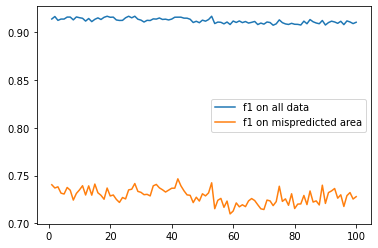

In [17]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()

In [18]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = DecisionTreeClassifier()
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='y')

Performance on all data
Precision: 0.9132002550985547
Recall: 0.913491246138002
F1 Score: 0.9133444750444061
y_actual_MD: 1270
y_predict_default_MD: 1270
y_pred_SMOTE_MD: 1270
y_pred_MAPS_MD: 1270

Default: (0.7348633513269902, 0.7377952755905511, 0.7360787539099432, None)
SMOTE: (0.7199682351021142, 0.7181102362204724, 0.7189745691257959, None)
MAPS: (0.736921239315599, 0.7401574803149606, 0.7382171840120091, None)


In [19]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Bank_Marketing_DT.csv')

# Just Train Twice

In [20]:
from helper import generate_JTT_Weights

In [21]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = DecisionTreeClassifier()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.9062877369149395
Recall: 0.9029424681598595
F1 Score: 0.9045116569943613


(0.9062877369149395, 0.9029424681598595, 0.9045116569943613, None)

In [22]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = DecisionTreeClassifier()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.9142921026230351
Recall: 0.9148153597175225
F1 Score: 0.9145493934278849
Performance on all data
Precision: 0.9120264461539893
Recall: 0.912755627482713
F1 Score: 0.9123830478666914
Performance on all data
Precision: 0.9135864925842225
Recall: 0.9152567309106959
F1 Score: 0.9143741346495577
Performance on all data
Precision: 0.9117266512734127
Recall: 0.9123142562895395
F1 Score: 0.9120153658371033
Performance on all data
Precision: 0.9164569115705572
Recall: 0.916875091952332
F1 Score: 0.9166630662870625
Performance on all data
Precision: 0.9100561651918319
Recall: 0.9112843901721348
F1 Score: 0.9106481266531642
Performance on all data
Precision: 0.9165045174188373
Recall: 0.9174635868765632
F1 Score: 0.9169678660656092
Performance on all data
Precision: 0.9171623319576273
Recall: 0.9177578343386789
F1 Score: 0.9174539074955905
Performance on all data
Precision: 0.915958480388473
Recall: 0.9162865970281007
F1 Score: 0.9161207718021399
Performance o

JTT Best weight on all is:  200
JTT Best f1 score on all:  0.9180604219807649


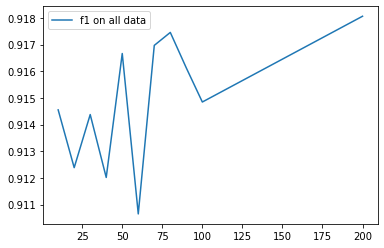

In [23]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [24]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = DecisionTreeClassifier()
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='y')

Performance on all data
Precision: 0.917935705644003
Recall: 0.9183463292629102
F1 Score: 0.9181380562642827
y_actual_MD: 1270
y_predict_default_MD: 1270
y_pred_SMOTE_MD: 1270
y_pred_MAPS_MD: 1270

Default: (0.7483010550649377, 0.7480314960629921, 0.748164373413583, None)
SMOTE: (0.7199682351021142, 0.7181102362204724, 0.7189745691257959, None)
MAPS: (0.736921239315599, 0.7401574803149606, 0.7382171840120091, None)
